In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup,AutoTokenizer,AutoModelForSequenceClassification
import pytorch_lightning as pl
from torchmetrics.functional.classification import accuracy,  multilabel_auroc as auroc
from torchmetrics import F1Score as f1
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

c:\Users\sern7\anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
BERT_MODEL_NAME = "airesearch/wangchanberta-base-att-spm-uncased"

In [3]:
import pandas as pd

df = pd.read_csv('cleaned_data.csv',index_col=False)
df

,Unnamed: 0,ticket_id,type,comment,ถนน,ทางเท้า,แสงสว่าง,ความปลอดภัย,น้ำท่วม,ความสะอาด,...,ป้าย,สัตว์จรจัด,PM25,สอบถาม,เสนอแนะ,คนจรจัด,การเดินทาง,ห้องน้ำ,ป้ายจราจร,labels
0,0,2021-BEJ9PP,['ถนน'],สะพานลอยกีดขวางทางเท้า ถนนเล็ก ควรทำเป็นทางข้า...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,2021-DDF9VX,"['คลอง', 'ความปลอดภัย', 'ทางเท้า']",ฟุตบาทยุบ และแคบมาก อันตรายที่จะพลัดตกลงคลองที...,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,2,2022-8TN97P,['จราจร'],เสาไฟจราจรเอียงจะล้ม,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,3,2022-GPUWCP,"['สายไฟ', 'ต้นไม้']",ต้นไม้สู้ชนสายไฟ,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."
4,4,2022-KNYYC3,"['คลอง', 'ความสะอาด']",การทิ้งขยะลงในลำคลอง,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207084,208671,2023-4989VN,"['ถนน', 'คลอง']",📢🔊🌳🍃🎋แจ้ง มีวัชพืช เลื้อยพัน และไต่ระดับขึ้นสู...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
207085,208672,UNWWLC,"['เสียงรบกวน', 'ถนน']",‘กรุณาอ่านข้อมูลบรรยายประกอบการปักหมุด’\n* ปัญ...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
207086,208673,PT24KT,['สัตว์จรจัด'],ปัญหา : ช่วยจัดการกับนกพิราบ จำนวนมาก\nจุดสังเ...,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
207087,208674,2023-GL4KWC,['ทางเท้า'],ทางเท้าแบบนี้สภาพไม่ดีเลย กรุณาปรับปรุงโดยด่วน,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
types = ['ถนน','ทางเท้า','แสงสว่าง','ความปลอดภัย','น้ำท่วม','ความสะอาด','กีดขวาง',
        'ท่อระบายน้ำ','สะพาน','จราจร','สายไฟ','คลอง','เสียงรบกวน','ต้นไม้','ร้องเรียน',
        'ป้าย','สัตว์จรจัด',"PM25",'สอบถาม','เสนอแนะ','คนจรจัด','การเดินทาง','ห้องน้ำ','ป้ายจราจร']

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2)
test_df, val_df = train_test_split(test_df, test_size=0.5)


In [7]:
tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

In [8]:
# bert_model = BertModel.from_pretrained('airesearch/wangchanberta-base-att-spm-uncased', return_dict=True)


In [9]:
BERT_MODEL_NAME = "airesearch/wangchanberta-base-att-spm-uncased"

In [10]:
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df[types].values
       
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 256, truncation=True,
                                return_tensors="pt") for text in df['comment']]

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        
        return torch.Tensor(self.labels[idx])
        

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        

        return batch_texts, batch_y

In [11]:
batch_size = 16

In [12]:
train_dataset = Dataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Dataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = Dataset(val_df)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
next(iter(train_loader))[1]

tensor([[1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:

model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME ,num_labels=len(types), return_dict=True,ignore_mismatched_sizes=True) 
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5) 
criterion = nn.BCELoss()
# scheduler = optim.lr_scheduler.LinearLR(optimizer)




Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wa

In [16]:
x = next(iter(train_loader))[0]

In [17]:
input = x['input_ids'].squeeze(1).to(device)

In [18]:
model(input).logits.shape

torch.Size([16, 24])

In [19]:
#train
EPOCHS = 1
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(EPOCHS):
    print('Epoch: {}/{}'.format(epoch+1, EPOCHS))
    model.train()
    buffer_loss = []
    for data in tqdm(train_loader):
        inputs, labels = data
        inputs = inputs['input_ids'].squeeze(1).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).logits
        outputs = F.sigmoid(outputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        buffer_loss.append(loss.item())
    train_losses.append(np.mean(buffer_loss))
    
    model.eval()
    with torch.no_grad():
        buffer_val_loss = []
        for data in tqdm(val_loader):
            inputs, labels = data
            inputs = inputs['input_ids'].squeeze(1).to(device)
            labels = labels.to(device)
            outputs = model(inputs).logits
            outputs = F.sigmoid(outputs)
            loss = criterion(outputs, labels)
            buffer_val_loss.append(loss.item())
        val_losses.append(np.mean(buffer_val_loss))
    
    # scheduler.step()
            
            
            
        
    print('Validation Loss: {:.4f}'.format(np.mean(val_losses)))
    print('Training Loss: {:.4f}'.format(np.mean(train_losses)))


        

    
        

Epoch: 1/1


  0%|          | 0/10355 [00:00<?, ?it/s]

c:\Users\sern7\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  0%|          | 0/1295 [00:00<?, ?it/s]

Validation Loss: 0.0359
Training Loss: 0.0792


In [20]:
torch.save(model,'multilabel.pth')

In [21]:
model = torch.load('multilabel.pth')

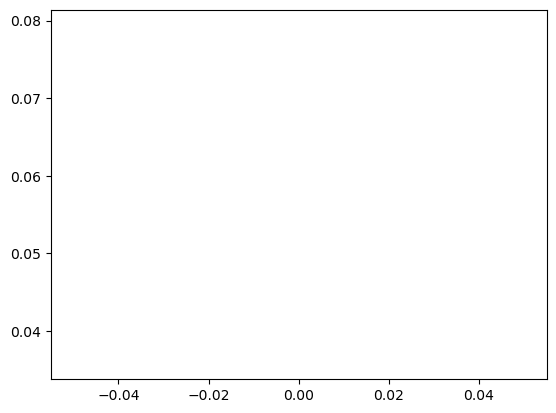

In [22]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')

plt.show()


In [23]:
#test 
y_pred=[]
y_label=[]
model.eval()
with torch.no_grad():
    buffer_val_loss = []
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs = inputs['input_ids'].squeeze(1).to(device)
        labels = labels.numpy().tolist()
        outputs = model(inputs).logits
        outputs = F.sigmoid(outputs)
        outputs = outputs.detach().cpu().numpy()
        for row in outputs:
            y_pred.append([1 if i>=0.5 else 0 for i in row])
        for row in labels:
            y_label.append([int(i) for i in row])
        
print(classification_report(y_true=y_label,y_pred=y_pred))
        

  0%|          | 0/1295 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7740
           1       0.91      0.93      0.92      3195
           2       0.93      0.95      0.94      2285
           3       0.85      0.87      0.86      2108
           4       0.93      0.91      0.92      1923
           5       0.94      0.91      0.93      1985
           6       0.85      0.87      0.86      1499
           7       0.82      0.88      0.85      1341
           8       0.87      0.92      0.89      1250
           9       0.82      0.87      0.84      1230
          10       0.91      0.95      0.93       937
          11       0.95      0.83      0.89       910
          12       0.89      0.91      0.90       871
          13       0.95      0.92      0.94       773
          14       0.72      0.54      0.61       742
          15       0.83      0.70      0.76       645
          16       0.95      0.89      0.92       429
          17       0.57    

c:\Users\sern7\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sern7\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predict

In [24]:
nan_df = pd.read_csv('nan_bucket_df.csv')

In [25]:
nan_df = nan_df.drop(columns=['Unnamed: 0'])

In [26]:
nan_df = nan_df[nan_df['comment'].isna()==0]

In [27]:
nan_df.isna().sum()

ticket_id     0
type         97
comment       0
dtype: int64

In [28]:
nan_df = nan_df.reset_index(drop=True)

In [29]:
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
class DatasetForPredict(torch.utils.data.Dataset):

    def __init__(self, data):
        
        self.ticket_id = data['ticket_id'].values
       
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 256, truncation=True,
                                return_tensors="pt") for text in data['comment']]

    def __len__(self):
        return len(self.ticket_id)

    def get_batch_id(self, idx):
        # Fetch a batch of labels
        
        return self.ticket_id[idx]
        

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_id = self.get_batch_id(idx)
        

        return batch_texts, batch_id

In [30]:
predict_dataset = DatasetForPredict(nan_df)
predict_loader = DataLoader(predict_dataset, batch_size=batch_size, shuffle=False)

In [44]:
def predictNan(predict_loader):
    
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for data in tqdm(predict_loader):
            inputs, ids = data
            inputs = inputs['input_ids'].squeeze(1).to(device)
            outputs = model(inputs).logits
            outputs = F.sigmoid(outputs)
            outputs = outputs.detach().cpu().numpy()
            for i in range(len(outputs)):
                pred = [1 if i>=0.5 else 0 for i in outputs[i]]
                pred_id = [ids[i]]+pred
                y_pred.append(pred_id)
            
            
    return y_pred
    

In [45]:
y_id, y_pred = predictNan(predict_loader)

  0%|          | 0/3842 [00:00<?, ?it/s]

In [50]:
nan_predicted = pd.DataFrame(y_pred,columns=['ticket_id']+types)

In [51]:
nan_predicted.to_csv('nan_predicted.csv')

# Predict with word

In [35]:
test_word = 'ไม่มีที่วางขยะรอจัดเก็บ วางไว้บนทางเท้า'

In [36]:
def predict(text):
    input = tokenizer(text,padding='max_length', max_length = 256, truncation=True,return_tensors="pt")
    input = input['input_ids'].squeeze(1).to(device)
    output = model(input).logits
    output = F.sigmoid(output)
    res = output.detach().cpu().numpy()
    
    return output

In [37]:
res = predict(test_word).detach().cpu().numpy()

In [38]:
res_pandas = pd.DataFrame(res,columns=types)

In [39]:
sort_res = res_pandas.sort_values(axis=1,by=0)

<BarContainer object of 24 artists>

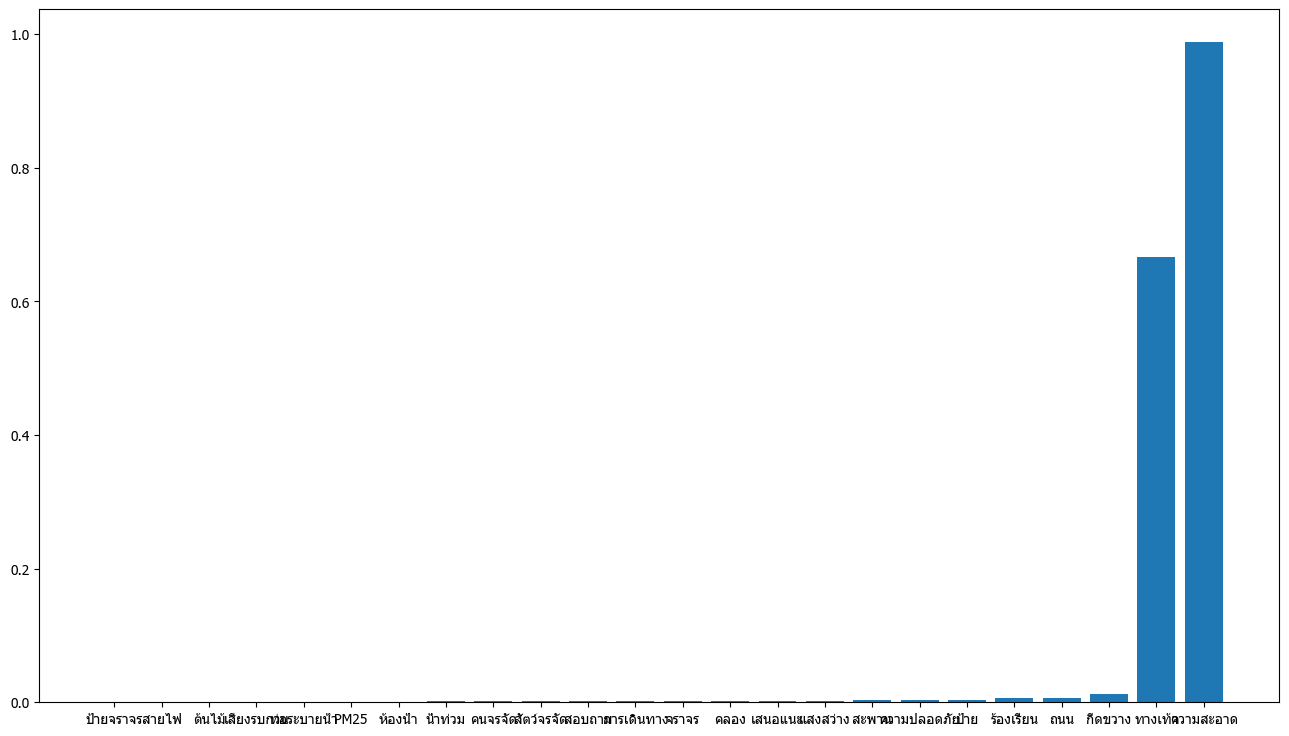

In [40]:
plt.rcParams['font.family']='Tahoma'
plt.figure(figsize=(16,9))
plt.bar(sort_res.columns,sort_res.loc[0])

In [41]:
types

['ถนน',
 'ทางเท้า',
 'แสงสว่าง',
 'ความปลอดภัย',
 'น้ำท่วม',
 'ความสะอาด',
 'กีดขวาง',
 'ท่อระบายน้ำ',
 'สะพาน',
 'จราจร',
 'สายไฟ',
 'คลอง',
 'เสียงรบกวน',
 'ต้นไม้',
 'ร้องเรียน',
 'ป้าย',
 'สัตว์จรจัด',
 'PM25',
 'สอบถาม',
 'เสนอแนะ',
 'คนจรจัด',
 'การเดินทาง',
 'ห้องน้ำ',
 'ป้ายจราจร']